# 2D-CNN for diabetic retinopathy detection

Diabetes mellitus (DM) is one of the largest public health concerns globally. According to estimates by the International Diabetes Federation, 536.6 million people had DM in 2021, and prevalence is projected to increase to 783.2 million by 2045. Diabetic retinopathy (DR) is a direct microvascular end organ complication of DM. High glucose level caused by DM produces cytokines and growth factors that lead to capillary damage of eye blood vessels and causes increased vascular permeability and capillary occlusions. According to a 2012 study, approximately 34.6% of DM patients suffer some degree of DR, 10. 2% suffering from vision-threatening DR. Early detection of the disease is very important and any delay can result in rapid vision degradation and eventual irreversible blindness. Traditionally, DR is detected manually by trained clinicians searching for various lesions, including microaneurysms, hemorrhages, hard and soft exudates and vascular abnormalities. To avoid complications related to DR, patients with DM are recommended to undergo annual examinations. The process requires highly skilled practitioners, with developing countries suffering from an acute shortage of such experts.

The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal of this homework is to build an automated detection system hopefully resulting in models with realistic clinical potential.

### Environment Preparation

Please first follow the instruction in the pdf file.

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
%cd "drive/MyDrive/data"

[Errno 2] No such file or directory: 'drive/MyDrive/data'
/content/drive/MyDrive/data


# Introduction

In [1]:
#set all the seeds
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2
def set_seed(seed = 0):
    tf.keras.utils.set_random_seed(seed)
    print(f"Seed set to {seed}")

To build a deep learning pipeline in tensorflow we will need to go over 3 steps:
- Building the dataset.
- Building the model.
- Building a custom training loop or use model.fit

# Part 1: Building the dataset

The first thing to do is to locate the path of our data. Here, our data are inside the train/val/test folder. Each of these folders contains a 0 and 1 folder with images of normal (0) and positive diabetic retinopathy (1).

In [39]:
TRAIN_PATH = "train"
TEST_PATH = "test"
VAL_PATH = "val"

Then we will ask tensorflow to store all the filenames that are in these folder in three dataset named train_ds, val_ds and test_ds

In [40]:
train_ds = tf.data.Dataset.list_files(TRAIN_PATH + "/*/*.png",shuffle = True)
val_ds = tf.data.Dataset.list_files(VAL_PATH + "/*/*.png",shuffle = False)
test_ds = tf.data.Dataset.list_files(TEST_PATH + "/*/*.png",shuffle = False)

We can count how many images have been found using the `len` function.

In [3]:
print(f"There are {len(train_ds)} images in the training set.")
print(f"There are {len(val_ds)} images in the validation set.")
print(f"There are {len(test_ds)} images in the test_ds set.")

There are 680 images in the training set.
There are 102 images in the validation set.
There are 194 images in the test_ds set.


We can access an element of a dataset using the following command:

In [4]:
next(iter(train_ds))

<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\work\\hw4-hw4_305295818_206266926\\data\\train\\1\\4b618537d52f.png'>

Furthermore, we can iterate through a tensorflow dataset like this:

In [5]:
i =0
for element in train_ds:
  print(element)
  if i== 5:
    break
  i+=1

tf.Tensor(b'C:\\work\\hw4-hw4_305295818_206266926\\data\\train\\1\\65c958379680.png', shape=(), dtype=string)
tf.Tensor(b'C:\\work\\hw4-hw4_305295818_206266926\\data\\train\\0\\f85fd4fac887.png', shape=(), dtype=string)
tf.Tensor(b'C:\\work\\hw4-hw4_305295818_206266926\\data\\train\\1\\2fde69f20585.png', shape=(), dtype=string)
tf.Tensor(b'C:\\work\\hw4-hw4_305295818_206266926\\data\\train\\1\\63b4d030b016.png', shape=(), dtype=string)
tf.Tensor(b'C:\\work\\hw4-hw4_305295818_206266926\\data\\train\\1\\165cd2070ebd.png', shape=(), dtype=string)
tf.Tensor(b'C:\\work\\hw4-hw4_305295818_206266926\\data\\train\\1\\14e3f84445f7.png', shape=(), dtype=string)


As you can see the variable stored in our dataset are some tensors, which contain a string structured as follow:

dataset/diagnosis/image_name,  where
- dataset is train, val or test.
- diagnosis is 0 or 1.
- image_name is the name of the image with the png extension.


We first need to create a parser function to help tensorflow to read our images and to know what is the corresponding label.


Lets first define a parse function. It will tell our tensorflow dataset how to read an image. Indeed, the first command line will extract the label while the two next ones will open the image. Finally, it will return the image normalized by 255 and the label.

In [13]:
def parse(image_path):
  label = tf.strings.to_number(tf.strings.split(image_path, '/')[1]) ## find the label (0 or 1) and convert it to float
  image = tf.io.read_file(image_path)
  image = tf.io.decode_png(image)
  return image/255,label


Let's apply this parsing function to our three datasets!

We will use this parse function with the `.map` method of the tensorflow dataset API. The map function is here to tell the dataset which function to apply when reading a file. To summarize, every time the dataset will need to open one image, it will apply the parse function to the file name of the image. We use it because we have too many images and we cannot load all of them in RAM. That is why we open them only when needed.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(parse, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(parse,num_parallel_calls = AUTOTUNE)
test_ds = test_ds.map(parse,num_parallel_calls = AUTOTUNE)


Now each iteration of our datasets should give us an image and a label. Let's see the use of `next(iter())`.

If the next cell fails, change the command line in `parse` from


`label = tf.strings.to_number(tf.strings.split(image_path, '/')[1]) ## find the label (0 or 1) and convert it to float`


to



`label = tf.strings.to_number(tf.strings.split(image_path, '\\')[1]) ## find the label (0 or 1) and convert it to float`

In [15]:
image,label = next(iter(train_ds))

In [16]:
image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.03921569, 0.03137255, 0.05098039],
        [0.03529412, 0.03137255, 0.05098039],
        [0.03921569, 0.03137255, 0.05490196],
        ...,
        [0.03921569, 0.03137255, 0.05098039],
        [0.03529412, 0.03137255, 0.05098039],
        [0.03529412, 0.03137255, 0.05490196]],

       [[0.03529412, 0.03137255, 0.05098039],
        [0.03921569, 0.03137255, 0.05098039],
        [0.03921569, 0.03137255, 0.05490196],
        ...,
        [0.03529412, 0.03137255, 0.05098039],
        [0.03529412, 0.03137255, 0.05098039],
        [0.03921569, 0.03137255, 0.05098039]],

       [[0.03921569, 0.03137255, 0.05098039],
        [0.03921569, 0.03137255, 0.05490196],
        [0.03921569, 0.03137255, 0.05490196],
        ...,
        [0.03529412, 0.03137255, 0.05098039],
        [0.03529412, 0.03137255, 0.05098039],
        [0.03529412, 0.03137255, 0.05098039]],

       ...,

       [[0.03921569, 0.03529412, 0.05490196],
        [0.04

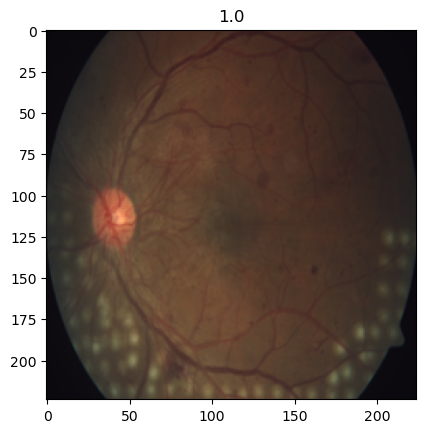

In [17]:
plt.imshow(image)
plt.title(label.numpy())
plt.show()

The last step is to create some data augmentation to make our model perfrom better.

This function should return a modified (image, label) pair, given an original (image, label) pair. We will couple this function with the `.map` function in order to read a different version of the pair (image,label) each time later on. Basically, this just means that every image that will be fed to the network will first be modified for instace by rotating and\or flipping.

In [18]:
def augmentation(image,label):
  # First we want to perform some random rotation of 0,90,180 or 270 degree. We can do it using the
  # tf.image.rot90 function. But before, we need to randomly sample an integer between 0 and 4 (excluded) in
  # order to know which angle we want (0 <-> 0), (1<->90), (2<->180),(3<->270)
  k = tf.random.uniform(shape = [], minval = 0, maxval = 4, dtype = tf.int32)
  # ----------TODO : apply the rotation to the image using tf.image.rot90 ------------
  image = tf.image.rot90(image, k = k)

  #------------------------------------------------------------------------------------------




  # ----------TODO : random sample a tf.float32 between 0 and 1 and name it proba------------
  proba = tf.random.uniform(shape = [], minval = 0, maxval = 1, dtype = tf.float32)

  #--------------------------------------------------------------------------------------------

  #We want to perform some random flipping of the image using tf.image.flip_up_down with probability 0.5:
  #We now define our condition to see if the probability is lower than 0.5 which mean that we want to apply the flipping
  # or higher than 0.5 which mean we will not apply anything
  flip_cond = tf.less(proba,0.5)

  #Now we want to apply the flipping when the flip_condition is true, for this we can use the tf.cond function
  #It works like a ternary operator:
  #tf.cond(a,b,c) will return b if a == True or c if a == False
  # If the proba is lower than 0.5 return the flipped image and store it inside image, otherwise return the retated image
  image = tf.cond(flip_cond,lambda: tf.image.flip_up_down(image), lambda: image)


  return image,label

In order to apply augmentaion to the training set, we use again the `.map` as mentioned but now with `augmentation` function:

In [19]:
train_ds = train_ds.map(augmentation, num_parallel_calls = AUTOTUNE)  # notice the augmentation argument

Now our dataset is just missing to be attributed with a batch size to be ready. This can be done with the following command:

In [20]:
BATCH_SIZE = 8
final_train_ds = train_ds.batch(BATCH_SIZE)
final_val_ds = val_ds.batch(BATCH_SIZE)
final_test_ds = test_ds.batch(BATCH_SIZE)

Notice that now the datasets are called `final_ds`.

# Part 2: Building the model

In this part you will have to build a 2D CNN using tensorflow. Complete the `build_model` function that should return your compiled model. Its' input size should be the same as our data (ie (224,224,3)). Notice that 3 on the right represents the channels (R,G,B). In general the dimension of images are $(B,H,W,C)$ meaning (the number of images per batch, image's number of rows,image's number of columns, number of channels).

Please use a ReLU activation for each of your Linear or Convolutional layer except the last one which should use a sigmoid activation.

Use $3\times 3$ kernel size for convolution layers and $(2,2)$ maxpooling size. Build 4 convolutional layers and two dense layers where the second one is with the size of 1 and sigmoid activation. For number of kernels in each convolutional layer and\or the number of neurons in the linear layer you may use `wandb`.

Please compile it within `build_model` using an adam optimizer with a learning rate of 1e-3 and a crossentropy loss with `reduction = SUM_OVER_BATCH_SIZE` and the accuracy as metric. The `SUM_OVER_BATCH_SIZE` makes the model to compute the average loss of the batch. Please make sure there is no sigmoid included inside your loss function (`from_logit` argument) because we already included it in the model definition.

In [21]:
def build_model():
  #----------- Implement your code here:--------------------------------------------------------------------
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE),
                  metrics=['accuracy'])
  #------------------------------------------------------------------------------------------------------
    return model

In [22]:
model = build_model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)      

# Part 3: Keras model.fit to train your model

Use `model.fit` to train your model. Since we are using tensorflow datasets, you will not need to specify x and y but only `final_train_ds`. You will also not need to specify a batch size because it is already included in our dataset above.
Please only specify validation_data = final_val_ds, and epochs = 10. Train the model with `fit` method:

In [23]:
set_seed()
model = build_model()
  #----------- Implement your code here:--------------------------------------------------------------------
model.fit(final_train_ds, validation_data = final_val_ds, epochs = 10)
  #------------------------------------------------------------------------------------------------------

Seed set to 0
Epoch 1/10



c:\Users\Oron\anaconda3\envs\bm-336546\lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



85/85 [==============================] - 22s 245ms/step - loss: 0.4693 - accuracy: 0.7529 - val_loss: 0.2105 - val_accuracy: 0.8824
Epoch 2/10
85/85 [==============================] - 20s 241ms/step - loss: 0.2568 - accuracy: 0.9015 - val_loss: 0.2057 - val_accuracy: 0.9314
Epoch 3/10
85/85 [==============================] - 20s 240ms/step - loss: 0.2520 - accuracy: 0.8912 - val_loss: 0.2080 - val_accuracy: 0.8922
Epoch 4/10
85/85 [==============================] - 21s 243ms/step - loss: 0.2123 - accuracy: 0.9294 - val_loss: 0.1471 - val_accuracy: 0.9608
Epoch 5/10
85/85 [==============================] - 21s 242ms/step - loss: 0.2203 - accuracy: 0.9250 - val_loss: 0.1738 - val_accuracy: 0.9118
Epoch 6/10
85/85 [==============================] - 20s 239ms/step - loss: 0.2143 - accuracy: 0.9279 - val_loss: 0.1355 - val_accuracy: 0.9510
Epoch 7/10
85/85 [==============================] - 21s 242ms/step - loss: 0.2049 - accuracy: 0.9235 - val_loss: 0.1346 - val_accuracy: 0.9412
Epoch 8/1

Evaluate your model on the final_test_ds, using model.evaluate.

In [24]:
  #----------- Implement your code here:--------------------------------------------------------------------
model.evaluate(final_test_ds)
  #------------------------------------------------------------------------------------------------------

25/25 [==============================] - 1s 38ms/step - loss: 0.2553 - accuracy: 0.9124


[0.25528907775878906, 0.9123711585998535]

Now we want to plot the confusion matrix of our model. The simplest way would be first to have a test dataset with a batch size of 1. We can build it here:

In [25]:
one_size_test_ds = test_ds.batch(1)

Then, we need to iterate through our dataset, store the labels inside `y_true` list. Right after that, you will need to store the prediction inside `y_pred` list.

Complete the following loop. Append the true label for each example to `y_true` and every predicted probability to `y_pred` using the trained model. Don't forget to use `.numpy().item()` for the labels and predictions. When estimating the probability using the model, set `training=False`.

In [26]:
y_true = []
y_pred = []

for image,label in tqdm(one_size_test_ds):
  #----------- Implement your code here:--------------------------------------------------------------------
  y_true.append(label.numpy().item())
  pred = model.predict(image)
  y_pred.append(pred[0,0])
  #------------------------------------------------------------------------------------------------------

  0%|          | 0/194 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


For more flexibility,  convert the lists `y_true` and `y_pred` into numpy array:

In [27]:
  #----------- Implement your code here:--------------------------------------------------------------------
y_true = np.array(y_true)
y_pred = np.array(y_pred)
  #------------------------------------------------------------------------------------------------------

In [28]:
print(f" y_true: {y_true}")
print(f"We have extracted the following predictions: {y_pred}")

 y_true: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 1.]
We have extracted the following predictions: [9.95144367e-01 3.46383713e-02 1.18290246e-01 5.18121906e-02
 7.26657152e-01 2.49606146e-05 3.54510918e-02 5.91012016e-02
 7.31304765e-01 3.73424068e-02 2.83903519e-05 1.21618733e-01
 6.51347041e-02 9.99990165e-01 9.99998271e-01 9.99151945e-01
 8.19590315e-02 9.45088685e-01 9.98504102e-01 3.66024897e-02
 2.99105614e-06 2.37683311e-01 8.57365191e-01 7.3

As you can see, our `y_pred` are the probability of being sick estimated by the net's weights and the final sigmoid. Apply a threshold of 0.5 which will label the predictions. If the probability will be higher than the threshold then the predicted label will be 1 and 0 otherwise. This function have to be written in a single line.

In [29]:
  #----------- Implement your code here:--------------------------------------------------------------------
y_pred = (y_pred > 0.5).astype(int)
  #------------------------------------------------------------------------------------------------------

In [30]:
print(f"We have extracted the following y_true: {y_true}")
print(f"We have extracted the following y_pred: {y_pred}")

We have extracted the following y_true: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 1.]
We have extracted the following y_pred: [1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0
 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1
 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1
 0 1 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1
 0 1 0 0 1 0 1 1 0 1 1 0 1 0

Now you need to compute the accuracy between `y_true` and `y_pred` from scratch (without using any other library than numpy). You have to do this in one line using `np.mean()`. Print it

In [31]:
  #----------- Implement your code here:--------------------------------------------------------------------
acc = np.mean(y_true == y_pred)
print(f'The model accuracy is: {acc:.5f}')
  #------------------------------------------------------------------------------------------------------

The model accuracy is: 0.91237


Let's plot the confusion matrix using sklearn:

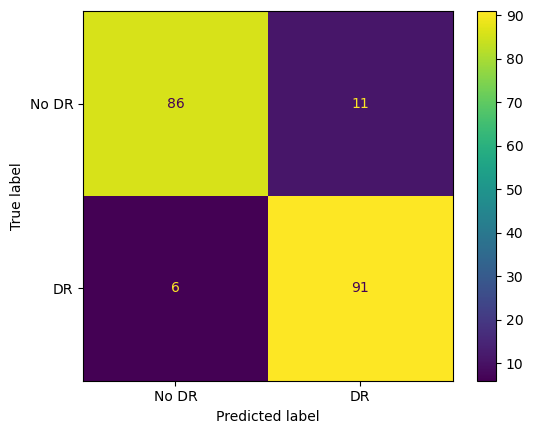

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["No DR","DR"])
disp.plot()


# Part 4: training the model with a customed training loop

Rebuild your model to reinitialize the weights:

In [34]:
  #----------- Implement your code here:--------------------------------------------------------------------
model = build_model()
  #------------------------------------------------------------------------------------------------------

Now you will need to fill the following `train_step` function. This function takes one batch of images `x`, and one batch of labels `y`. It feeds the `x` into the model, compute the loss function on this batch, then perform the gradient descent and return the updated loss function.

In [35]:
@tf.function
def train_step(x,y,model):
  y = tf.reshape(y,(-1,1))
  with tf.GradientTape() as tape:
    ##------------TO DO pred = the prediction of the model on x and the loss.
    pred = model(x)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y, pred)
    ##-----------------------------------------------------------------------------------------------------
  #The two following lines make the update of the gradient descent
  grads = tape.gradient(loss, model.trainable_weights)
  model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
  accuracy = tf.cast(tf.round(pred) == y,tf.int32)  # division by the number of examples will take place later on
  return loss,accuracy

You will also need to implement validation by `val_step` function. This function takes one batch of images `x` and one batch of labels `y` and returns the loss function without performing any gradient descent.

In [36]:
@tf.function
def val_step(x,y,model):
  y = tf.reshape(y,(-1,1))
  ##------------TO DO pred = the prediction of the model on x and the loss.
  pred = model(x)
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y, pred)
  #-----------------------------------------------------------------------------------
  accuracy = tf.cast(tf.round(pred) == y,tf.int32)  # division by the number of examples will take place later on
  return loss,accuracy

Train your model:

In [37]:
epochs = 10
for epoch in range(epochs):
  epoch_loss = 0
  epoch_accuracy = 0
  n=0
  for image,label in (pbar := tqdm(final_train_ds)):
    ##------------TO DO perform the train step on image and label, store the output in a variable named loss.
    loss, accuracy = train_step(image, label, model)
    epoch_loss += tf.reduce_sum(loss)
    epoch_accuracy += tf.reduce_sum(accuracy)
    n += image.shape[0]
    ##---------------------------------------------------------------------------------------------------
    pbar.set_description("Train Epoch number : {}, loss = {}, accuracy {}".format(epoch,epoch_loss/n,epoch_accuracy/n))

  epoch_val_loss = 0
  n=0
  epoch_val_accuracy = 0
  ##### Perform the validation step
  for image,label in (pbar := tqdm(final_val_ds)):
    ##------------TO DO perform the val step on image and label, store the output in a variable named val_loss.
    loss, accuracy = val_step(image, label, model)
    epoch_val_loss += tf.reduce_sum(loss)
    epoch_val_accuracy += tf.reduce_sum(accuracy)
    n += image.shape[0]
    ##------------------------------------------------------------------------------------------------
    pbar.set_description("Val Epoch number : {}, loss = {}, accuracy {}".format(epoch,epoch_val_loss/n, epoch_val_accuracy/n))


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

For the predictions and the labels, apply the same as several cells before.

In [38]:
y_true = []
y_pred = []

for image,label in tqdm(one_size_test_ds):
  #----------- Implement your code here:--------------------------------------------------------------------
  y_true.append(label.numpy().item())
  pred = model.predict(image)
  y_pred.append(pred[0,0])
  #------------------------------------------------------------------------------------------------------

  0%|          | 0/194 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Convert into numpy, label the prediction using threshold of 0.5 and print the accuracy:

In [39]:
  #----------- Implement your code here:--------------------------------------------------------------------
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred = (y_pred > 0.5).astype(int)
acc = np.mean(y_pred == y_true)
print(f'The model accuracy is: {acc:.5f}')
  #------------------------------------------------------------------------------------------------------

The model accuracy is: 0.91753


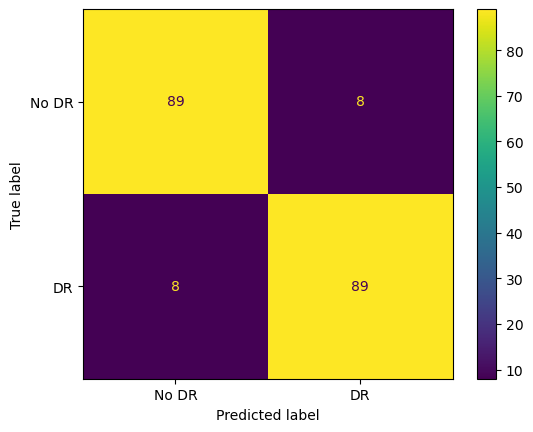

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["No DR","DR"])
disp.plot()


# Qualitative results:

We will now take 20 images from the shuffled testset and evaluate the performance:

  0%|          | 0/194 [00:00<?, ?it/s]

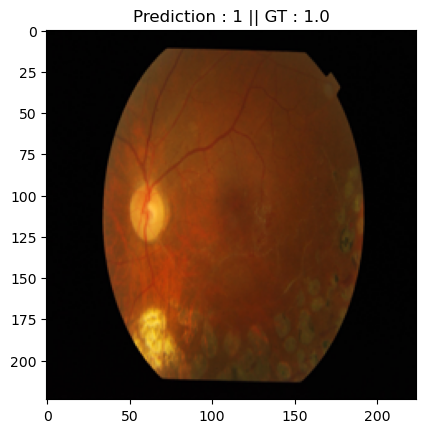

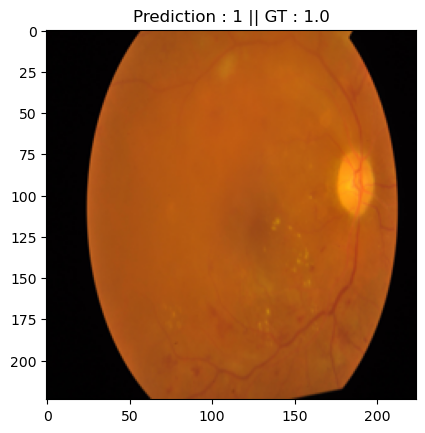

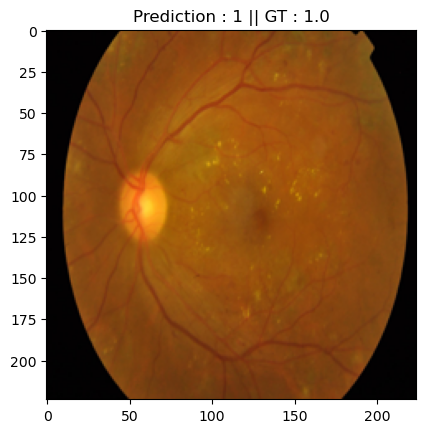

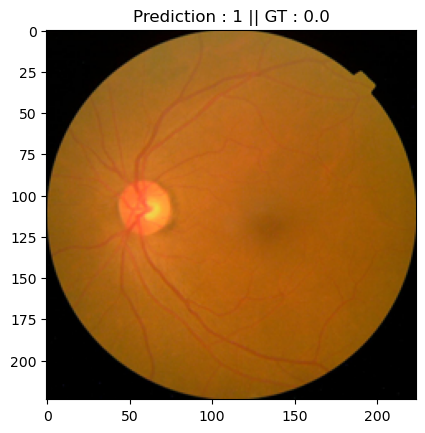

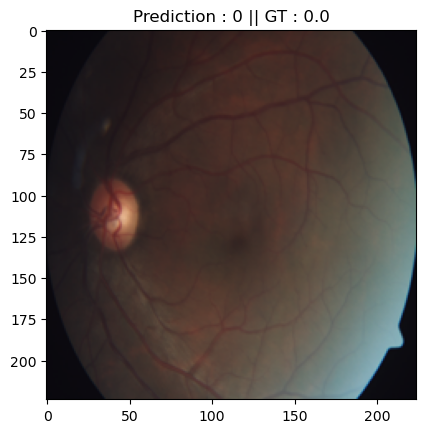

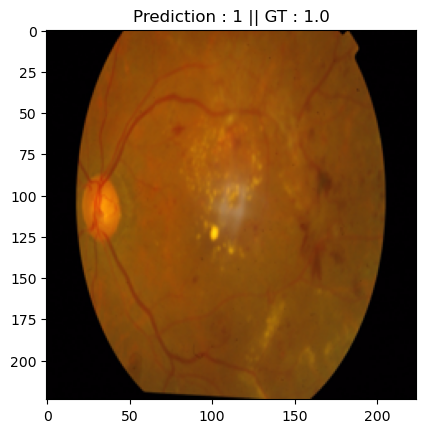

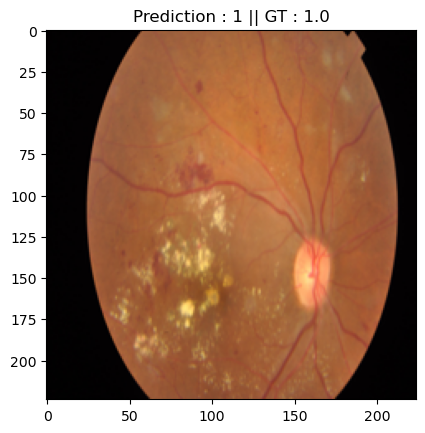

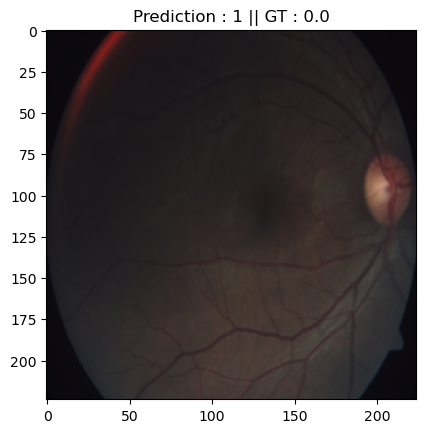

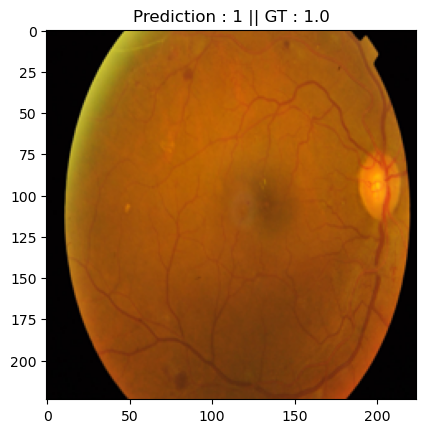

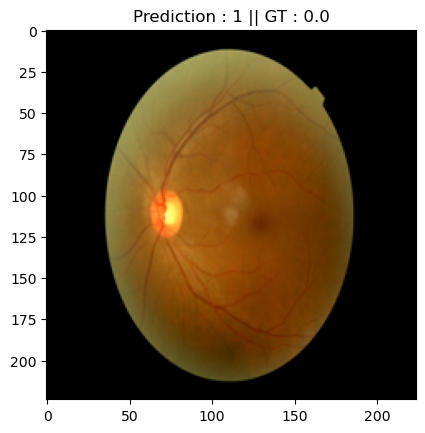

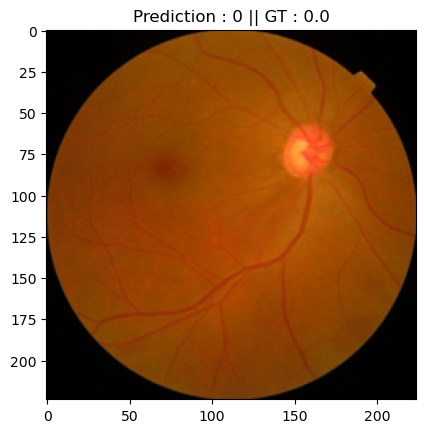

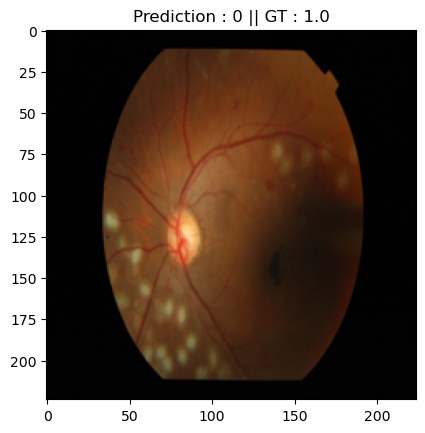

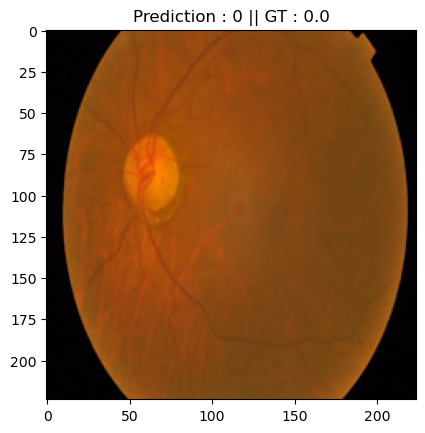

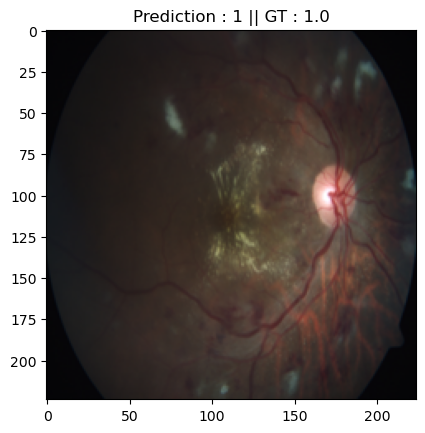

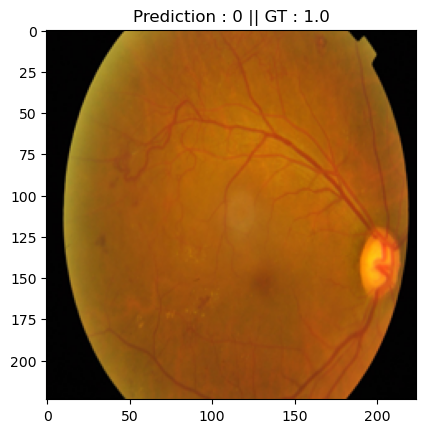

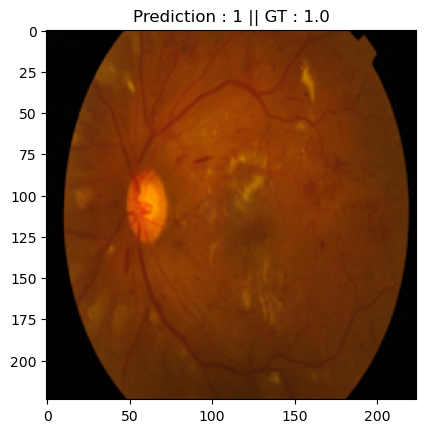

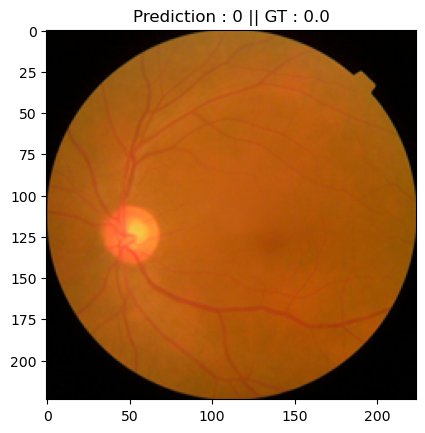

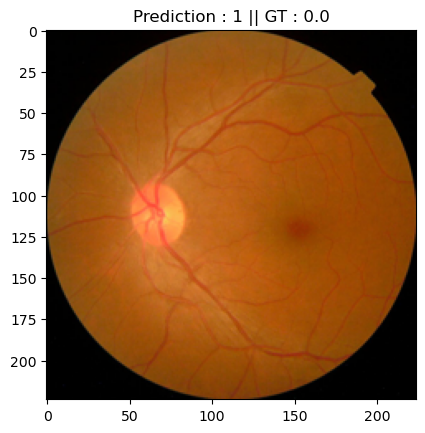

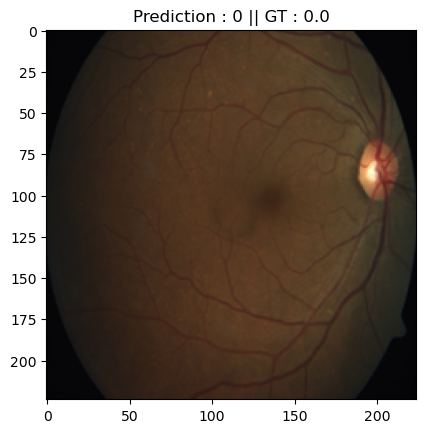

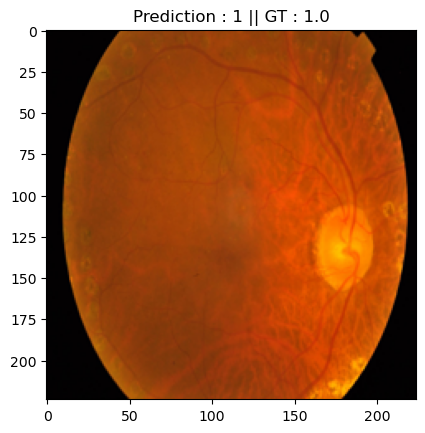

In [50]:
import random
zipped_list = list(zip(one_size_test_ds, y_pred))
random.shuffle(zipped_list)
n = 0
for (x,y_true), curr_y_pred in tqdm(zipped_list):
  plt.imshow(x[0])
  plt.title(f"Prediction : {curr_y_pred} || GT : {y_true.numpy().item()}")
  plt.show()
  n+=1
  if n>= 20:
      break

You should have quite good results as expected from the measured accuracy. Write a function for error analysis that will find and plot the images that the model failed to predict correctly. Can you tell by at least some of the images why it failed?


# Answer:
It seems that DR is characterized by spots on the retina, caused by capillary damage of eye blood vessels. The model has learned to recognize those patterns which has different color and brightness from their neighborhood. Some of the images there are spots that maybe originate from other source (noise maybe?) that the model confuse with retinal damage pattern.


In [42]:
def error_analysis(zipped_list):
    for (x,y_true), curr_y_pred in tqdm(zipped_list):
        ## --------------------------------TODO:------------------
        y_true = int(y_true.numpy().item())
        if y_true and not curr_y_pred:
          plt.imshow(x[0])
          plt.title(f"FN - Prediction : {curr_y_pred} || GT : {y_true}")
          plt.show()
        if not y_true and curr_y_pred:
          plt.imshow(x[0])
          plt.title(f"FP - Prediction : {curr_y_pred} || GT : {y_true}")
          plt.show()
        ##---------------------------------------------------------

Let's say that for some reason, you decide that it is more important to never miss any DR patient. This means that we want our false negative number to be 0, even if it make some false positive patient being 1.
What can control these rates once the model alreday trained? Change the parmeter that controls these rates and plot the confusion matrix that has minimal FNR.

# Answer:
The only parameter that we can control after model is trained is the threshold for class score prediction. The model output is continuous number in range [0,1] that represents the score of how likely the model think a sample is positive or negative. In the simple case we divide the two categories in half, setting the threshold at 0.5. If we want to be more cautious, and not to miss any true positive DR patient, we can lower the threshold (as we did, to 0.2), and include less likely patients in the positive predicted DR group. This of course is costing us in higher FP rate.

  0%|          | 0/194 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
The model accuracy is: 0.91753


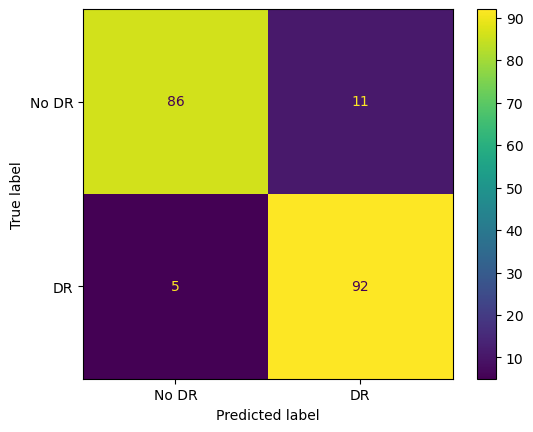

In [49]:
  #----------- Implement your code here:--------------------------------------------------------------------
y_true = []
y_pred = []

for image,label in tqdm(one_size_test_ds):
    y_true.append(label.numpy().item())
    pred = model.predict(image)
    y_pred.append(pred[0,0])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred = (y_pred > 0.2).astype(int) # lowering threshold for predicting DR
acc = np.mean(y_pred == y_true)
print(f'The model accuracy is: {acc:.5f}')

cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["No DR","DR"])
disp.plot()

  #------------------------------------------------------------------------------------------------------

GOOD LUCK!